In [1]:
import sys
sys.path.append('../')

In [6]:
datapath = '/data/submit/submit-illustris/april/data/results'
figpath = '/home/submit/aqc/frb_project/figures'

In [3]:
import numpy as np
from numpy.linalg import norm
import pandas as pd
import os
import healpy as hp

import matplotlib.pyplot as plt
from matplotlib import rcdefaults

In [5]:
plt.style.use('seaborn-v0_8-colorblind')
plt.style.use({'font.family': 'Times New Roman',
               'font.sans-serif': ['Bitstream Vera Sans'],
               'text.usetex': True,
               'mathtext.fontset': 'stixsans',
               'xtick.direction': 'out',
               'ytick.direction': 'out',
               'savefig.dpi': 150})

### Writing my own flat sky cross power estimator

See https://numpy.org/doc/stable/reference/routines.fft.html#module-numpy.fft for how the 2D FFT is done

Let us call the input array $a(\vec{m})$. If it has dimension $(N_0, N_1)$, then $m = (m_0, m_1)$ with $m_0 \in \{0, \ldots, N_0-1\}$ and $m_1 \in \{0, \ldots, N_1-1\}$.

The 2D Fourier transform (as implemented in `numpy`) is defined as 
$$A(\vec{n}) = A_{n_0, n_1} = \sum_{m_0, m_1} a_{m_0, m_1} \exp\left(-2\pi i\left(\frac{n_0}{N_0}m_0 + \frac{n_1}{N_1}m_1\right)\right)$$
with $n_0 \in \{0, \ldots, N_0-1\}$ and $n_1 \in \{0, \ldots, N_1-1\}$.

This is the output of `np.fft.fft2`. At this point it is helpful to shift the $n$s such that $n = 0, 1, \ldots, -n/2, \ldots, -1$, so that we can account for the positive and negative frequencies.

After shifting, the corresponding wavenumber to some $n$ is $\frac{2\pi n}{N}$. Scaling this by the pixel size $s$ to get $\ell$,
$$\vec{\ell} = \frac{2\pi}{s}\left(\frac{n_0}{N_0},\frac{n_1}{N_1}\right)  $$

Therefore, if we have $\vec{\theta} = s\vec{m}$ (up to a constant), then
$$A(\vec{\ell}) = A(\vec{n}(\vec{\ell})) = \sum_{\vec{\theta}} a(\vec{\theta}) \exp(-i\vec{\ell} \cdot \vec{\theta}) $$

To compute the cross correlation coefficients (see my [notes](https://www.overleaf.com/project/65da4664effb352b8f6f9b13)):
$$C_\ell^{ab} = \frac{s^2}{N_0 N_1}\langle A(\vec{\ell})^* B(\vec{\ell}^\prime) \rangle = \frac{s^2}{N_0 N_1}\frac{1}{\mathrm{\#\, of |\vec{\ell}|=\ell}} \sum_{|\vec{\ell}|=\ell} A(\vec{\ell})^* B(\vec{\ell}) $$

In [4]:
def cross_power_estimator(arr_a, arr_b, s, delta_ell, ell_max=None):
    # s: pixel size

    N_0, N_1 = arr_a.shape
    
    f_a = np.fft.fft2(arr_a)
    f_b = np.fft.fft2(arr_b) 
    f_ab = np.real(np.conjugate(f_a)*f_b)
    
    # scale
    vec_ells = np.indices((N_0, N_1), dtype=float)
    for i, N in zip((0,1), (N_0, N_1)): 
        vec_ells[i][ vec_ells[i] >= np.ceil(N/2) ] -= N #effectively, this is fftshift
        vec_ells[i] /= N
    vec_ells = 2*np.pi/s * vec_ells
    ells = norm(vec_ells, axis=0)
    
    if ell_max is None:
        ell_max = np.amax(ells)
    ell_bins = np.arange(0, ell_max, delta_ell)
    counts, _ = np.histogram(ells.flatten(), bins=ell_bins)
    tot, _ = np.histogram(ells.flatten(), bins=ell_bins, weights=f_ab.flatten())

    ell_mids = ell_bins[:-1]+delta_ell/2
    res = (s**2 / (N_0 * N_1)) * tot/counts
    mask = np.nonzero(counts)
    
    return ell_mids[mask], res[mask]

### cross power estimator from CMB summer school

In [7]:
# from https://github.com/jeffmcm1977/CMBAnalysis_SummerSchool/blob/master/CMB_School_Part_04.ipynb
def calculate_2d_spectrum(Map1,Map2,pix_size, delta_ell,ell_max, N):
    "calcualtes the power spectrum of a 2d map by FFTing, squaring, and azimuthally averaging"
    N=int(N)
    # make a 2d ell coordinate system
    ones = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) /(N-1)
    kX = np.outer(ones,inds) / (pix_size)
    kY = np.transpose(kX)
    K = np.sqrt(kX**2. + kY**2.)
    ell_scale_factor = 2. * np.pi 
    ell2d = K * ell_scale_factor
    
    # make an array to hold the power spectrum results
    N_bins = int(ell_max/delta_ell)
    ell_array = np.arange(N_bins)
    CL_array = np.zeros(N_bins)
    
    # get the 2d fourier transform of the map
    FMap1 = np.fft.ifft2(Map1)
    FMap2 = np.fft.ifft2(Map2)
    PSMap = np.fft.fftshift(np.real(np.conj(FMap1) * FMap2))
    # fill out the spectra
    i = 0
    while (i < N_bins):
        ell_array[i] = (i + 0.5) * delta_ell
        inds_in_bin = ((ell2d >= (i* delta_ell)) * (ell2d < ((i+1)* delta_ell))).nonzero()
        CL_array[i] = np.mean(PSMap[inds_in_bin])
        #print i, ell_array[i], inds_in_bin, CL_array[i]
        i = i + 1
 
    # return the power spectrum and ell bins
    return(ell_array,CL_array*np.sqrt(pix_size)*2.)

## Flat sky res=0.001 rad, galaxy shell at z=0.2

In [7]:
df = pd.read_hdf(os.path.join(datapath, 'test_flat_res001_shell.hdf5'))
df

,DM,N_g
0,543.007911,77
1,392.020168,55
2,377.327152,56
3,325.322239,41
4,335.768318,24
...,...,...
32395,311.358084,75
32396,309.400499,108
32397,576.706769,94
32398,520.455418,85


In [8]:
shape = np.array((180,180))

DMs = np.array(df['DM']).reshape(shape)
N_gs = (np.array(df['N_g']).reshape(shape) / df['N_g'].mean()) - 1

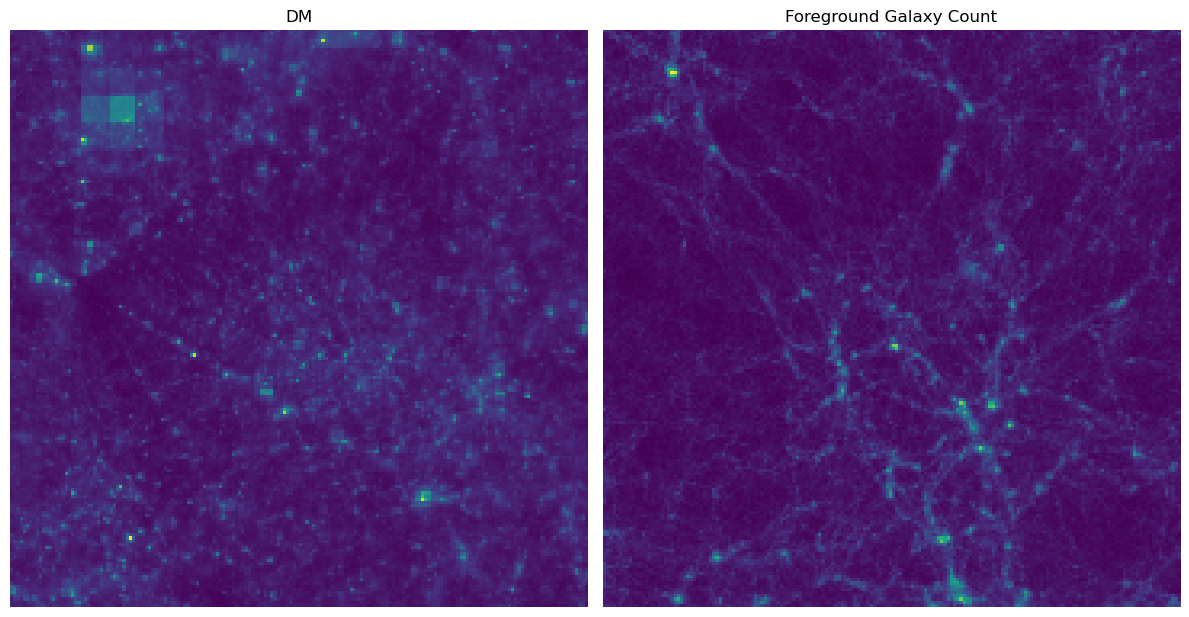

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 20), sharex=True, sharey=True)

axes[0].imshow(DMs)
axes[0].set_title('DM')
axes[0].axis('off')

axes[1].imshow(N_gs)
axes[1].set_title('Foreground Galaxy Count')
axes[1].axis('off')

plt.tight_layout()
# plt.savefig(os.path.join(figpath, 'test_flat_res001_shell_heatmap.png'), bbox_inches='tight')

## Flat Sky: res=0.001 rad

In [8]:
dfpath = os.path.join(datapath,'test_flat_res001.hdf5')
df = pd.read_hdf(dfpath)

### examine data

In [7]:
df

,DM,N_g
0,543.007911,807
1,392.020168,884
2,377.327152,812
3,325.322239,1128
4,335.768318,824
...,...,...
32395,311.358084,783
32396,309.400499,816
32397,576.706769,702
32398,520.455418,675


In [8]:
shape = np.array((180,180))

DMs = np.array(df['DM']).reshape(shape)
N_gs = (np.array(df['N_g']).reshape(shape) / df['N_g'].mean()) - 1

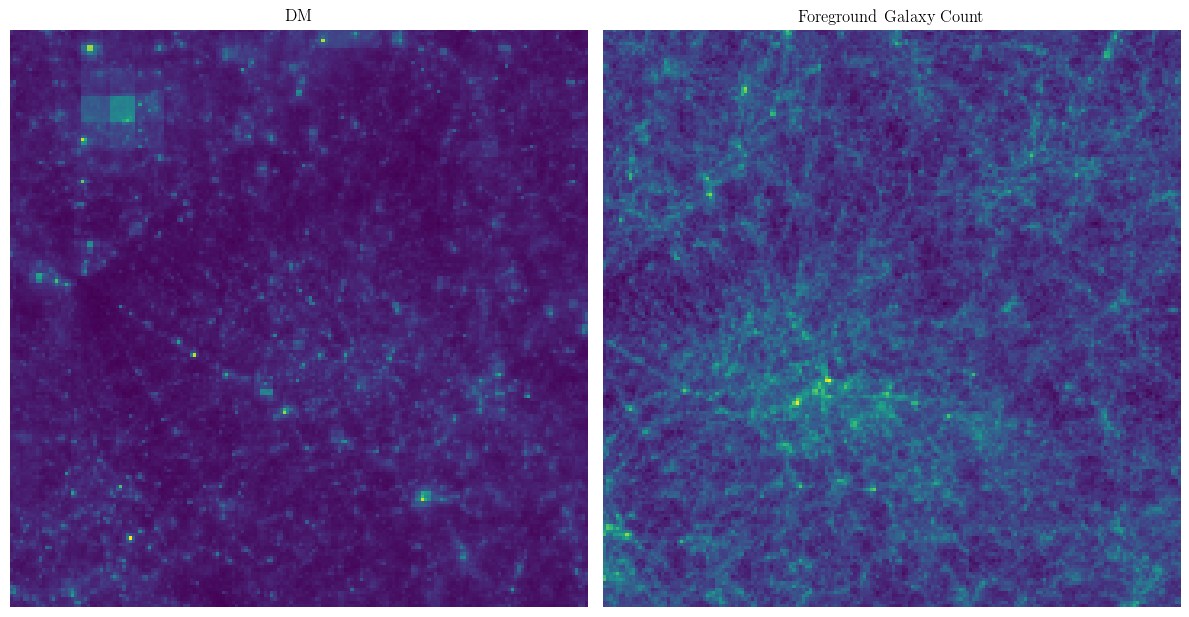

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 20), sharex=True, sharey=True)

axes[0].imshow(DMs)
axes[0].set_title('DM')
axes[0].axis('off')

axes[1].imshow(N_gs)
axes[1].set_title('Foreground Galaxy Count')
axes[1].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(figpath, 'test_flat_res001_heatmap.png'), bbox_inches='tight')

In [12]:
fig, ax = plt.subplots()

ax.scatter(df['DM'], df['N_g'], s=2)
ax.set_xlabel(r'DM (pc cm$^{-3}$)')
ax.set_ylabel('Number of foreground galaxies')
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

# plt.savefig(os.path.join(figpath, 'test_flat_res001_scatter.png')) 

(0.0, 2507.6)

Error in callback <function _draw_all_if_interactive at 0x7f7f8c55f7f0> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: Failed to process string with tex because dvipng could not be found

RuntimeError: Failed to process string with tex because dvipng could not be found

<Figure size 640x480 with 1 Axes>

### power spectrum

In [16]:
#my cross power estimator

ells, C_ls = cross_power_estimator(DMs, N_gs, 0.001, delta_ell=50)

(-0.15, 0.25)

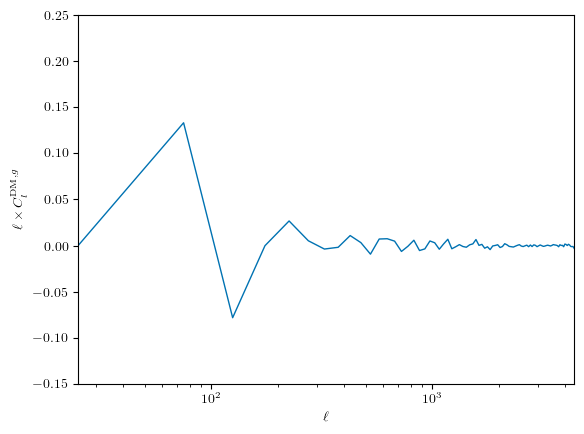

In [17]:
plt.plot(ells, ells*C_ls, lw=1)
plt.xscale('log')
plt.ylabel(r'$\ell \times C_l^{\mathrm{DM}, g}$')
plt.xlabel(r'$\ell$')

plt.xlim((ells[0], ells[-1]))
plt.ylim((-0.15, 0.25))

In [19]:
#summer school cross power estimator

ells_, C_ls_ = calculate_2d_spectrum(DMs, N_gs, 0.001, 50, 4416, 180)

(-0.15, 0.25)

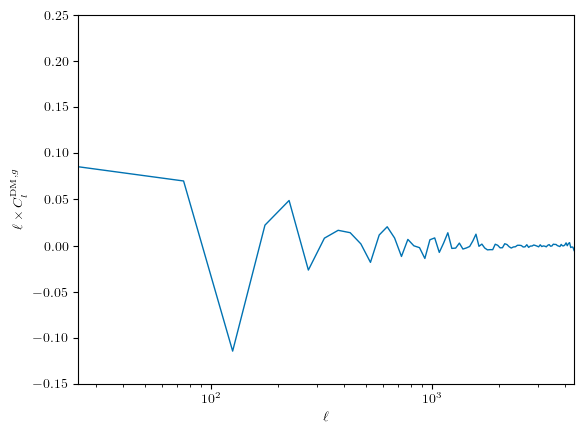

In [20]:
plt.plot(ells_, ells_*C_ls_, lw=1)
plt.xscale('log')
plt.ylabel(r'$\ell \times C_l^{\mathrm{DM}, g}$')
plt.xlabel(r'$\ell$')

plt.xlim((ells[0], ells[-1]))
plt.ylim((-0.15, 0.25))

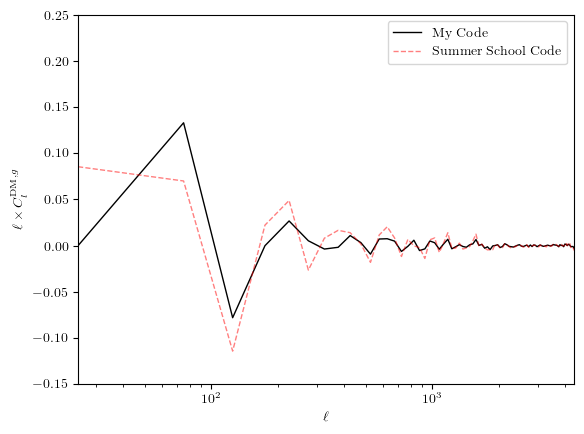

In [21]:
#let's overlay them
plt.plot(ells, ells*C_ls, lw=1, color='k', label='My Code')
plt.plot(ells_, ells_*C_ls_, lw=1, color='r', alpha=0.5, linestyle='--', label='Summer School Code')

plt.xscale('log')
plt.ylabel(r'$\ell \times C_l^{\mathrm{DM}, g}$')
plt.xlabel(r'$\ell$')

plt.xlim((ells[0], ells[-1]))
plt.ylim((-0.15, 0.25))

plt.legend()
# plt.savefig(os.path.join(figpath, 'test_flat_res001_PS_compare.png'), bbox_inches='tight')

Text(0.5, 1.0, 'Galaxy Overdensity Power Spectrum')

findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream V

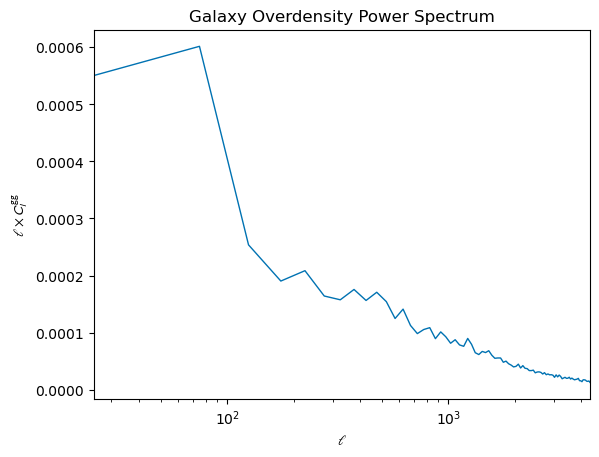

In [13]:
ells_gg, C_ls_gg = cross_power_estimator(N_gs, N_gs, 0.001, delta_ell=50) #autocorrelation
plt.plot(ells_gg, ells_gg*C_ls_gg, lw=1)
plt.xscale('log')
plt.ylabel(r'$\ell \times C_l^{\mathrm{gg}}$')
plt.xlabel(r'$\ell$')

plt.xlim((ells_gg[0], ells_gg[-1]))
plt.title('Galaxy Overdensity Power Spectrum')

## Flat Sky: res=0.01 rad

In [ ]:
datapath = '/home/tnguser/frb_project/data/test_flat_res01.hdf5'
df = pd.read_hdf(datapath)

(0.0, 133095.2)

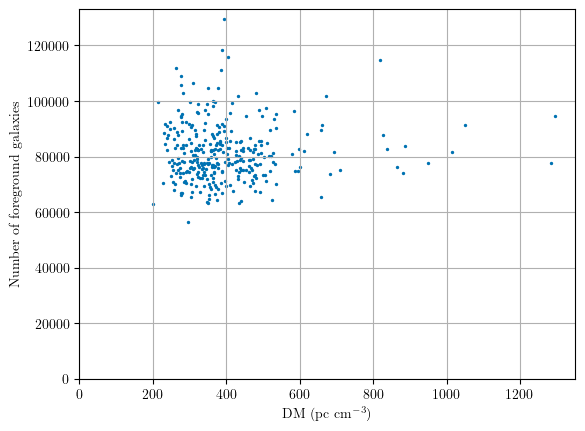

In [6]:
plt.scatter(df['DM'], df['N_g'], s=2)
plt.xlabel(r'DM (pc cm$^{-3}$)')
plt.ylabel('Number of foreground galaxies')
plt.xlim(left=0)
plt.ylim(bottom=0)

In [43]:
shape = np.array((18,18))

DMs = np.array(df['DM']).reshape(shape)
N_gs = (np.array(df['N_g']).reshape(shape) / df['N_g'].mean()) - 1 #galaxy overdensity field
ells, C_ls = cross_power_estimator(DMs, N_gs, 0.01)

Text(0.5, 0, '$\\ell$')

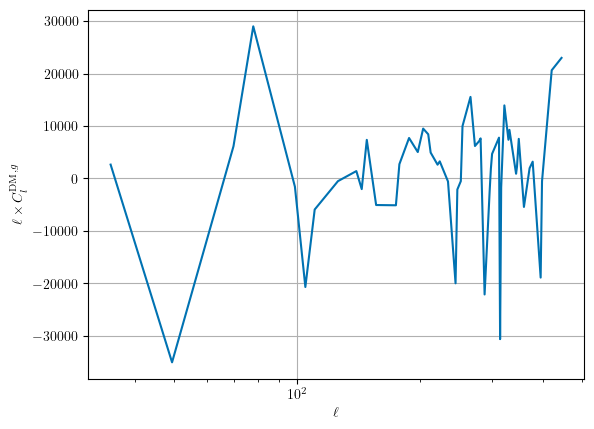

In [44]:
plt.plot(ells, ells*np.real(C_ls))
plt.xscale('log')
plt.ylabel(r'$\ell \times C_l^{\mathrm{DM}, g}$')
plt.xlabel(r'$\ell$')

In [65]:
shape = np.array((18,18))

DMs = np.array(df['DM']).reshape(shape)
N_gs = (np.array(df['N_g']).reshape(shape) / df['N_g'].mean()) - 1 #galaxy overdensity field
ells, C_ls = calculate_2d_spectrum(DMs, N_gs, 40, 400, 0.01, shape[0])

Text(0.5, 0, '$\\ell$')

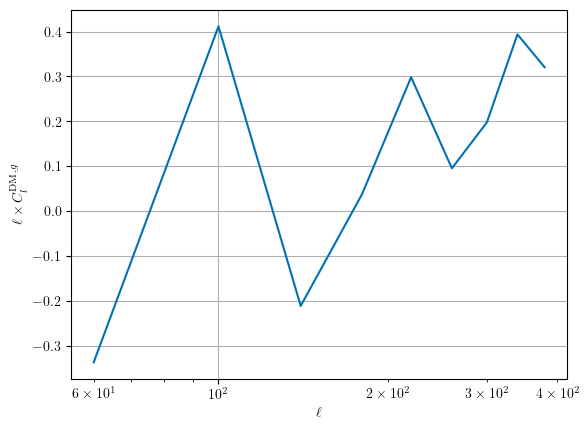

In [66]:
plt.plot(ells[1:], (ells*np.real(C_ls))[1:])
plt.xscale('log')
plt.ylabel(r'$\ell \times C_l^{\mathrm{DM}, g}$')
plt.xlabel(r'$\ell$')

## Full spherical harmonic transform with healpy: nside=64

In [69]:
nside=128
datapath = f'/home/tnguser/frb_project/data/test_nside{nside}.hdf5'

In [70]:
df = pd.read_hdf(datapath)
df

,DM,N_g
90370,422.465899,52473
90371,452.089202,53200
90372,410.856370,43449
90373,417.519176,53042
90374,337.060859,55115
...,...,...
105738,321.664284,43643
105739,571.127321,44142
105740,325.106797,40938
105741,304.781413,52278


In [58]:
def hp_cross_power_estimator(arr_a, arr_b, pixels, nside):
    s2 = hp.nside2pixarea(nside)
    fsky = s2*len(pixels)/(4*np.pi)
    N = hp.nside2npix(nside)
    
    a = np.zeros(N)
    a[pixels] = arr_a/s2
    
    b = np.zeros(N)
    b[pixels] = arr_b/s2
    
    alm_a = hp.sphtfunc.map2alm(a)
    alm_b = hp.sphtfunc.map2alm(b)
    
    return hp.sphtfunc.alm2cl(alm_a, alm_b) / fsky

In [71]:
delta_g = df['N_g']/df['N_g'].mean() - 1
C_ls = hp_cross_power_estimator(df['DM'], delta_g, df.index, nside)

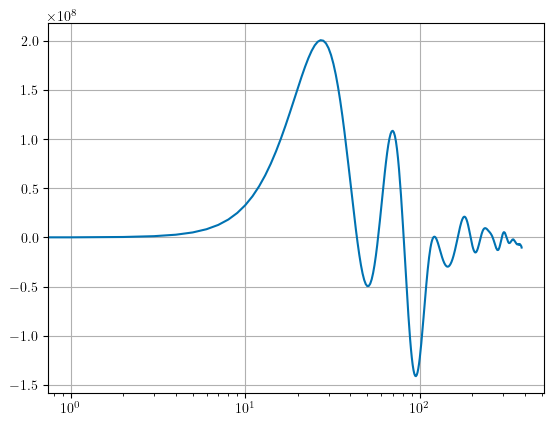

In [72]:
ls = np.arange(len(C_ls))
plt.plot(ls, ls*C_ls)
plt.xscale('log')